In [ ]:
!pip install sklearn
!pip install mlxtend

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = pd.read_csv("dataset.csv")
dataset = dataset.sample(frac = 1).reset_index(drop = True)

In [4]:
dataset.head(5)

,Day,Month,Airline,Origin,Destination,Scheduled Departure,Departure Time,Departure Delay,Scheduled Arrival,Arrival Time,Arrival Delay,Actual Time,Distance,Status
0,29,1,Virgin America,McCarran International Airport,Los Angeles International Airport,1745,1745.0,0.0,1906,1851.0,-15.0,66.0,236.0,0
1,8,3,Virgin America,McCarran International Airport,San Francisco International Airport,1426,1417.0,-9.0,1601,1552.0,-9.0,95.0,414.0,0
2,20,1,Virgin America,Palm Springs International Airport,San Francisco International Airport,1930,1912.0,-18.0,2102,2034.0,-28.0,82.0,421.0,0
3,25,2,Virgin America,Dallas Love Field,San Francisco International Airport,800,753.0,-7.0,1000,942.0,-18.0,229.0,1476.0,0
4,17,2,Virgin America,Los Angeles International Airport,McCarran International Airport,1248,1242.0,-6.0,1400,1405.0,5.0,83.0,236.0,1


### Preparing dataset for modeling
        Before solving the problem by using machine learning algorithms, I will prepare the data set and perform final cleanings:
        1. Remove Airline (the airline are Virgin America).
        2. Remove Arrival Delay (there is a Status column that represent which flight has delyad or not).
        3. Using OneHot encoding for the categorial features : Origin and Destination

In [5]:
dataset.drop(["Arrival Delay","Airline"] , inplace = True ,axis = 1)
dataset = pd.get_dummies(dataset , columns = ['Origin','Destination'])

### Principal Component Analysis
    Since the data set is very large and contains 64 features, we would like to reduce the dimensionality of the data set
    and preserve as much information as possible.
    For this purpose, we will use the Principal Component Analysis method which is a technique commonly used for reducing the dimensionality of data while preserving as much as possible of the information contained in the original data. PCA achieves this goal by projecting 
    data onto a lower-dimensional subspace that retains most of the variance among the data points.

    first of all , we need to search the amount of components that retains the most of the variance by the function : explained_variance_ratio_ 

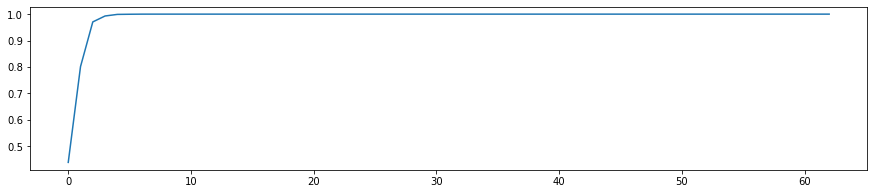

In [6]:
from sklearn.decomposition import PCA
X = dataset.drop('Status' , axis = 1)
plt.rcParams["figure.figsize"] = (15,3)
pca_test = PCA(n_components = 63)
pca_test.fit(X)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))

    As you can see, there are 5 components that describe 99 percent of the variance in the dataset, 
    So we will reduce the dimension of the data set to 5 dimensions and see if the results of the models change.

In [7]:
pca = PCA(n_components = 5)
principal_components = pca.fit_transform(X)
principal_components.shape

(12676, 5)

In [8]:
reduced_dataset = pd.DataFrame(data = principal_components , columns = ['PC1','PC2','PC3','PC4','PC5'])
reduced_dataset

,PC1,PC2,PC3,PC4,PC5
0,-1171.106916,-774.488235,49.257251,-41.310802,21.916410
1,-1027.928825,-141.835769,-9.620813,-36.237339,15.795304
2,-963.717415,-1127.594529,65.122817,-46.572417,43.729696
3,-33.041566,1166.863839,-105.644300,-29.814119,15.679437
4,-1226.942120,195.912882,-42.089143,-1.899219,4.418946
...,...,...,...,...,...
12671,1221.825201,-1041.298418,-75.304716,-22.343504,37.814650
12672,106.277423,-1071.290861,-294.180634,-8.844462,34.436674
12673,-243.899044,-197.931755,-220.997369,-0.310336,16.664534
12674,-1207.292240,1543.281936,-115.495629,-11.835478,3.441363


In [9]:
final_dataset = pd.concat([reduced_dataset ,  dataset.Status] , axis = 1)
final_dataset = final_dataset.reset_index(drop = True)
final_dataset

,PC1,PC2,PC3,PC4,PC5,Status
0,-1171.106916,-774.488235,49.257251,-41.310802,21.916410,0
1,-1027.928825,-141.835769,-9.620813,-36.237339,15.795304,0
2,-963.717415,-1127.594529,65.122817,-46.572417,43.729696,0
3,-33.041566,1166.863839,-105.644300,-29.814119,15.679437,0
4,-1226.942120,195.912882,-42.089143,-1.899219,4.418946,1
...,...,...,...,...,...,...
12671,1221.825201,-1041.298418,-75.304716,-22.343504,37.814650,0
12672,106.277423,-1071.290861,-294.180634,-8.844462,34.436674,0
12673,-243.899044,-197.931755,-220.997369,-0.310336,16.664534,1
12674,-1207.292240,1543.281936,-115.495629,-11.835478,3.441363,0


The use of the various algorithms will be done by the **Sklearn library**, which provides a convenient library for various models in machine learning,
tools for analyzing the model performance and more.

In [10]:
y = final_dataset.Status
X = final_dataset.drop('Status' , axis = 1)
x_train, x_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size = 0.3, random_state = 1)
y_train = y_train.ravel() #change the shape of y_train to (number of sampels , )

In [11]:
def evaluate (model ,x_train , y_train , x_test , y_test ):
    
    train_size = x_train.shape[0]
    epochs = 10
    batch_size = 512
    classes = np.unique(y_train)
    scores_train = []
    scores_test = []

    epoch = 1
    while epoch <= epochs:
        print(f' Epoch number : {epoch}')
        random_perm = np.random.permutation(train_size)
        mini_batch = 0
        while True:
            indices = random_perm [mini_batch : mini_batch + batch_size]
            model.fit(x_train[indices], y_train[indices])
            mini_batch += batch_size

            if mini_batch >= train_size:
                break

        scores_train.append(model.score(x_train, y_train))
        scores_test.append(model.score(x_test, y_test))

        epoch += 1

    return scores_train , scores_test

In [12]:
def plot_learning_curve(scores_train , scores_test):
    print(f' Train Accuracy : {np.max(scores_train)} Validation Accuracy : {np.max(scores_test)}')
    print(f' The best number of epochs for training : {np.argmax(scores_test)}')
    plt.plot(scores_train, color='blue', marker='o', markersize=5, label = 'Training Accuracy')
    plt.plot(scores_test, color='green', marker='+', markersize=5, linestyle='--', label= 'Validation Accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

In [13]:
def plot_confusion_matrix(matrix, score):
    plt.figure(figsize=(9,9))
    sns.heatmap(matrix, annot=True, fmt = ".3f", linewidths=.5, square = True, cmap = 'Greens');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);

### Logistic Regression

 Epoch number : 1
 Epoch number : 2
 Epoch number : 3
 Epoch number : 4
 Epoch number : 5
 Epoch number : 6
 Epoch number : 7
 Epoch number : 8
 Epoch number : 9
 Epoch number : 10
 Train Accuracy : 0.7424771779555956 Validation Accuracy : 0.7246910333946884
 The best number of epochs for training : 3


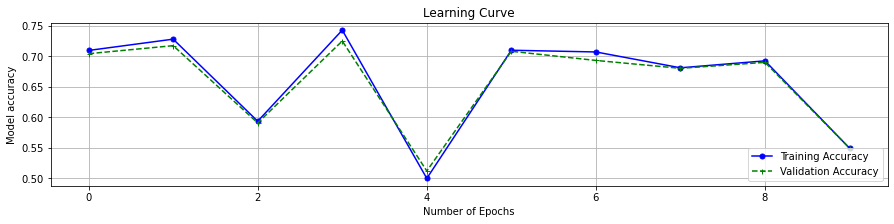

              precision    recall  f1-score   support

 Not Delayed       0.53      0.64      0.58      1866
     Delayed       0.57      0.46      0.51      1937

    accuracy                           0.55      3803
   macro avg       0.55      0.55      0.55      3803
weighted avg       0.55      0.55      0.55      3803



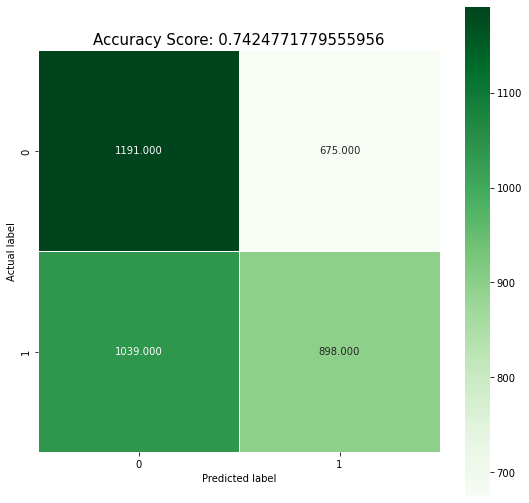

In [14]:
logistic_regression = make_pipeline(StandardScaler(),LogisticRegression(max_iter = 100 , solver = 'lbfgs'))
scores_train , scores_test = evaluate(logistic_regression , x_train , y_train , x_test , y_test)
plot_learning_curve(scores_train , scores_test)
cm = metrics.confusion_matrix(y_test, logistic_regression.predict(x_test))
score = np.max(scores_train)
plot_confusion_matrix(cm, score)
print(classification_report(y_test, logistic_regression.predict(x_test), target_names= ['Not Delayed','Delayed']))

### Neural Network (MLP)

 Epoch number : 1
 Epoch number : 2
 Epoch number : 3
 Epoch number : 4
 Epoch number : 5
 Epoch number : 6
 Epoch number : 7
 Epoch number : 8
 Epoch number : 9
 Epoch number : 10
 Train Accuracy : 0.9087118223825087 Validation Accuracy : 0.9071785432553248
 The best number of epochs for training : 8


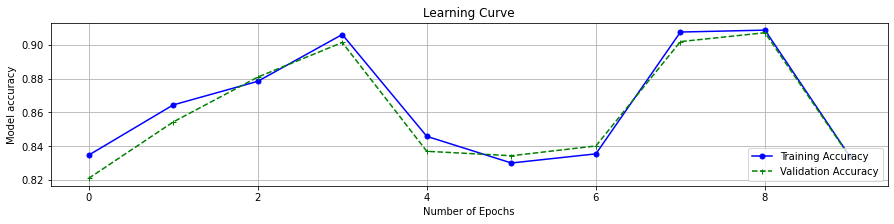

              precision    recall  f1-score   support

 Not Delayed       0.79      0.90      0.84      1866
     Delayed       0.89      0.77      0.83      1937

    accuracy                           0.83      3803
   macro avg       0.84      0.84      0.83      3803
weighted avg       0.84      0.83      0.83      3803



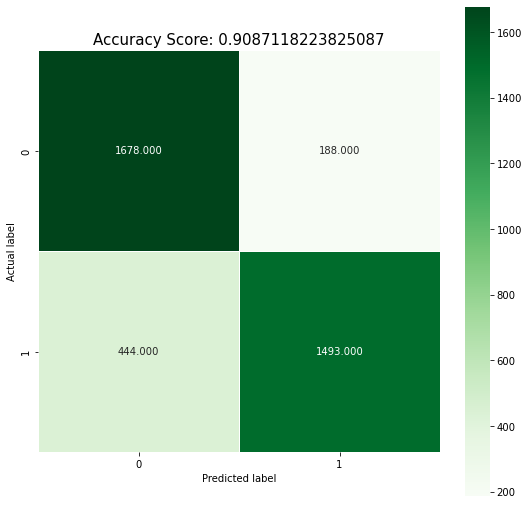

In [15]:
neural_network = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes = (128,64), activation="relu" , random_state = 1))
scores_train , scores_test = evaluate(neural_network , x_train , y_train , x_test , y_test)
plot_learning_curve(scores_train , scores_test)
cm = metrics.confusion_matrix(y_test, neural_network.predict(x_test))
score = np.max(scores_train)
plot_confusion_matrix(cm, score)
print(classification_report(y_test, neural_network.predict(x_test), target_names= ['Not Delayed','Delayed']))

### K Nearest Neighbors (KNN)

 Epoch number : 1
 Epoch number : 2
 Epoch number : 3
 Epoch number : 4
 Epoch number : 5
 Epoch number : 6
 Epoch number : 7
 Epoch number : 8
 Epoch number : 9
 Epoch number : 10
 Train Accuracy : 0.72850219767835 Validation Accuracy : 0.7110176176702603
 The best number of epochs for training : 4


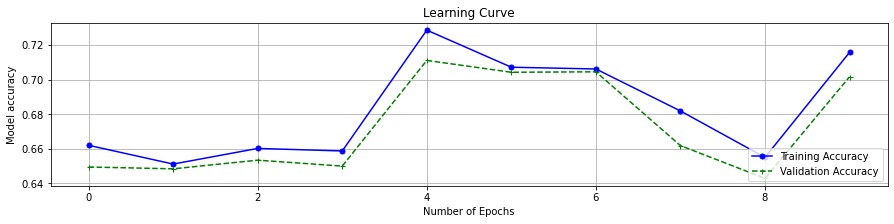

              precision    recall  f1-score   support

 Not Delayed       0.66      0.80      0.72      1866
     Delayed       0.76      0.61      0.67      1937

    accuracy                           0.70      3803
   macro avg       0.71      0.70      0.70      3803
weighted avg       0.71      0.70      0.70      3803



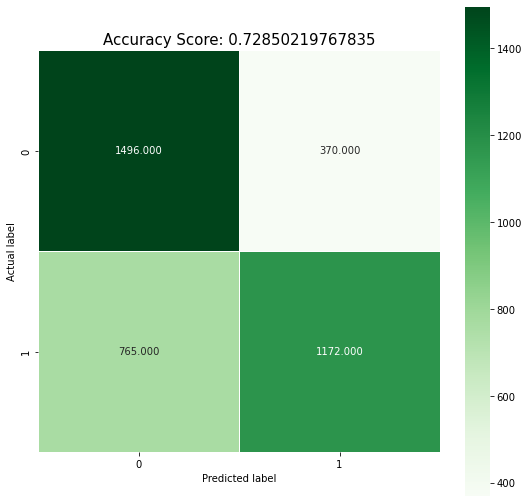

In [16]:
knn = make_pipeline(StandardScaler() , KNeighborsClassifier(n_neighbors = 5))
scores_train , scores_test = evaluate(knn , x_train , y_train , x_test , y_test)
plot_learning_curve(scores_train , scores_test)
cm = metrics.confusion_matrix(y_test, knn.predict(x_test))
score = np.max(scores_train)
plot_confusion_matrix(cm, score)
print(classification_report(y_test, knn.predict(x_test), target_names= ['Not Delayed','Delayed']))

### Random Forest

 Epoch number : 1
 Epoch number : 2
 Epoch number : 3
 Epoch number : 4
 Epoch number : 5
 Epoch number : 6
 Epoch number : 7
 Epoch number : 8
 Epoch number : 9
 Epoch number : 10
 Train Accuracy : 0.9107404485517863 Validation Accuracy : 0.9082303444648961
 The best number of epochs for training : 7


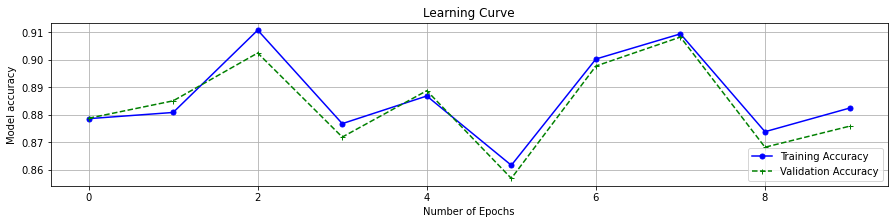

              precision    recall  f1-score   support

 Not Delayed       0.82      0.96      0.88      1866
     Delayed       0.95      0.80      0.87      1937

    accuracy                           0.88      3803
   macro avg       0.89      0.88      0.88      3803
weighted avg       0.89      0.88      0.88      3803



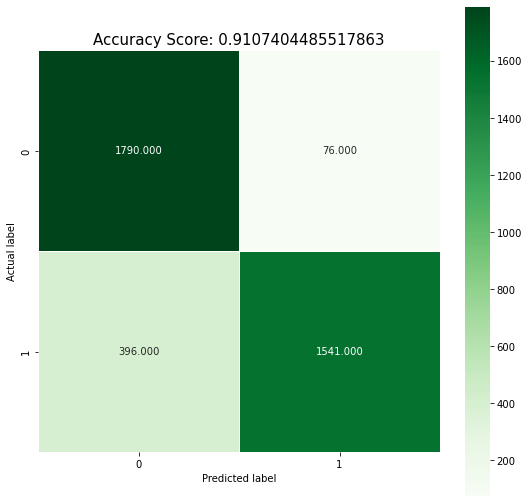

In [17]:
random_forest = make_pipeline(StandardScaler() , RandomForestClassifier(n_estimators = 100))
scores_train , scores_test = evaluate(random_forest , x_train , y_train , x_test , y_test)
plot_learning_curve(scores_train , scores_test)
cm = metrics.confusion_matrix(y_test, random_forest.predict(x_test))
score = np.max(scores_train)
plot_confusion_matrix(cm, score)
print(classification_report(y_test, random_forest.predict(x_test), target_names= ['Not Delayed','Delayed']))